In [2]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [1]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
22 ... nummod
- ... punct
year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [6]:
df=pd.read_csv("/content/train_data.csv",engine='python')
df.shape

(24118, 7)

In [7]:
df.head(2)

,Unnamed: 0,Theme,Paragraph,Question,Answer_possible,Answer_text,Answer_start
0,2,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed ...",When did Beyonce leave Destiny's Child and become a solo singer?,True,['2003'],[526]
1,6,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed ...",What album made her a worldwide known artist?,True,['Dangerously in Love'],[505]


In [9]:
df1=pd.DataFrame(df['Paragraph'])
df1

,Paragraph
0,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed ..."
1,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed ..."
2,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed ..."
3,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed ..."
4,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed ..."
...,...
24113,"About 98% of Antarctica is covered by the Antarctic ice sheet, a sheet of ice averaging at least 1.6 km (1.0 mi) thick. The continent has about 90% of the world's ice (and thereby about 70% of the..."
24114,"About 98% of Antarctica is covered by the Antarctic ice sheet, a sheet of ice averaging at least 1.6 km (1.0 mi) thick. The continent has about 90% of the world's ice (and thereby about 70% of the..."
24115,"About 98% of Antarctica is covered by the Antarctic ice sheet, a sheet of ice averaging at least 1.6 km (1.0 mi) thick. The continent has about 90% of the world's ice (and thereby about 70% of the..."
24116,"About 98% of Antarctica is covered by the Antarctic ice sheet, a sheet of ice averaging at least 1.6 km (1.0 mi) thick. The continent has about 90% of the world's ice (and thereby about 70% of the..."


In [13]:
df1.iloc[0]

Paragraph    Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed ...
Name: 0, dtype: object

In [17]:
doc = nlp("Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas,")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Beyoncé ... compound
Giselle ... compound
Knowles ... compound
- ... punct
Carter ... nsubj
( ... punct
/biːˈjɒnseɪ/ ... punct
bee ... compound
- ... punct
YON ... compound
- ... punct
say ... appos
) ... punct
( ... punct
born ... acl
September ... npadvmod
4 ... nummod
, ... punct
1981 ... nummod
) ... punct
is ... ROOT
an ... det
American ... amod
singer ... attr
, ... punct
songwriter ... appos
, ... punct
record ... compound
producer ... conj
and ... cc
actress ... conj
. ... punct
Born ... ROOT
and ... cc
raised ... conj
in ... prep
Houston ... pobj
, ... punct
Texas ... appos
, ... punct


In [16]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [18]:
get_entities("Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas,")

['Giselle Knowles Carter', 'American record Houston']

In [20]:
entity_pairs = []

for i in tqdm(df1["Paragraph"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 24118/24118 [08:26<00:00, 47.57it/s]


In [21]:
entity_pairs[10:20]

[['fifth studio album', 'darker  themes'],
 ['fifth studio album', 'darker  themes'],
 ['fifth studio album', 'darker  themes'],
 ['fifth studio album', 'darker  themes'],
 ['fifth studio album', 'darker  themes'],
 ['fifth studio album', 'darker  themes'],
 ['influential Forbes magazine', 'female  2015'],
 ['influential Forbes magazine', 'female  2015'],
 ['influential Forbes magazine', 'female  2015'],
 ['influential Forbes magazine', 'female  2015']]

In [28]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [29]:
get_relation("John completed the task")

'completed'

In [34]:
relations = [get_relation(i) for i in tqdm(df1['Paragraph'])]
pd.Series(relations).value_counts(ascending=True)[:20]

100%|██████████| 24118/24118 [07:58<00:00, 50.38it/s]


designated            1
resided at            1
found in many         1
catered               1
proved beneficial     1
is among              1
provide post          1
sprang                1
runs from             1
denote                1
designated as         1
For                   1
identified several    1
stepped               1
work                  1
conducted joint       1
lower                 1
involves              1
wearing               1
quit                  1
dtype: int64

In [35]:
pd.Series(relations).value_counts()[40:50]

provides       52
set            51
states         50
returned to    47
served as      47
consists of    47
see            47
brought        46
known as       46
named          46
dtype: int64

In [31]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [32]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [ ]:
'''plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()'''

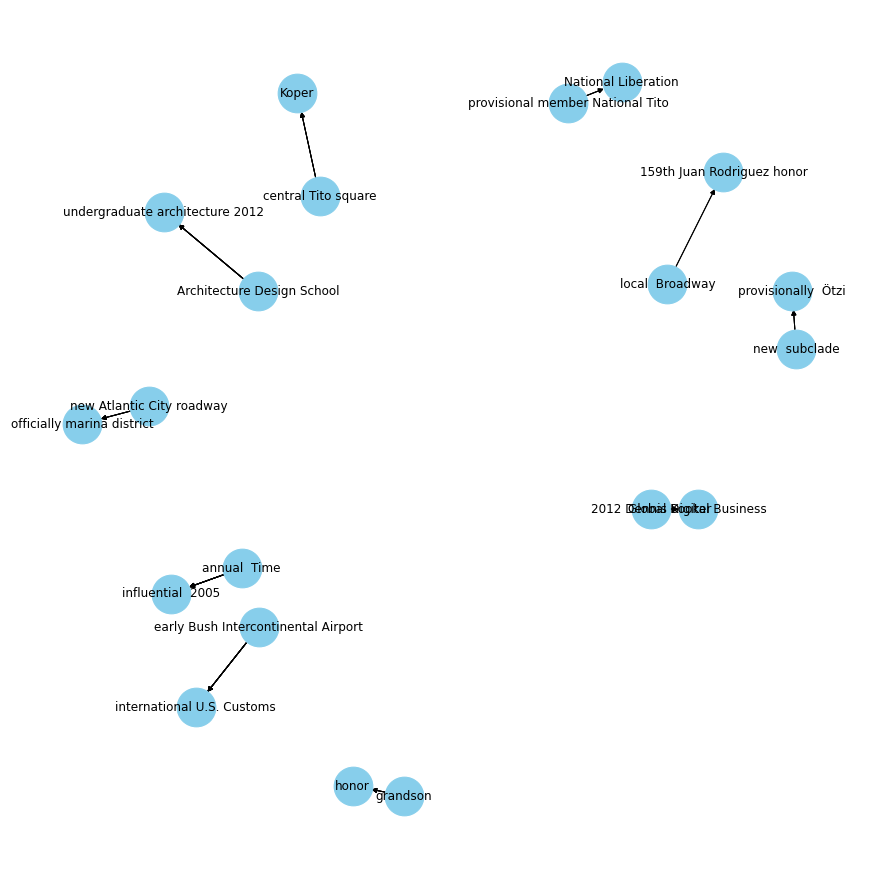

In [36]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="named"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()